In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from keras.models import Sequential
import tensorflow as tf
from keras.layers import *
from keras.optimizers import *

Using TensorFlow backend.
C:\Users\arung\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\arung\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\arung\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\arung\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Set parameters here 
INPUT_SIZE = 256
mapping = {0:'COVID-19', 1:'NORMAL',2:'OTHER',3:'PNEUMONIA'}
NUMCLASSES = len(mapping)
BATCH_SIZE = 16
VAL_BATCH_SIZE = 1
folder = r'C:\Users\arung\OneDrive\Desktop\COVID 19 Chest Xray\nih'
SEED = 12345
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [3]:
from skimage import exposure

def preprocess(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    # Histogram Equalization
    #img_eq = exposure.equalize_hist(img)

    # Adaptive Equalization
    #img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    return img_rescale


In [4]:
train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_whitening=False,
                                zca_epsilon=1e-06,
                                rotation_range=10,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                brightness_range=None,
                                shear_range=0.0,
                                zoom_range=0.05,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=1./255,
                                preprocessing_function=preprocess,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )


In [5]:
df = pd.read_csv(folder + r'\fourClassFiles.csv')
df = df.sample(frac=1)
print(df['label'].value_counts())

NORMAL       350
OTHER        350
COVID-19     327
PNEUMONIA    234
Name: label, dtype: int64


In [6]:


training_set = train_datagen.flow_from_dataframe(
                                            dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            validate_filenames=True
                                        )

validation_set = train_datagen.flow_from_dataframe( dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=VAL_BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='validation',
                                            interpolation="nearest",
                                            validate_filenames=True
                                            )

Found 703 validated image filenames belonging to 4 classes.
Found 175 validated image filenames belonging to 4 classes.


C:\Users\arung\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 383 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [7]:

#from sklearn.model_selection import train_test_split
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

model = Sequential()

model.add(InputLayer(input_shape=[INPUT_SIZE,INPUT_SIZE,3])) #keras will internally add batch dimension

model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))


model.add(Flatten())


model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(2,activation='softmax'))


model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)      

In [8]:
model.load_weights('model-normalized-fresh.h5')


ValueError: You are trying to load a weight file containing 11 layers into a model with 9 layers.

In [13]:
new_model = Sequential()
new_model.add(InputLayer(input_shape=[INPUT_SIZE,INPUT_SIZE,3])) #keras will internally add batch dimension
for layer in model.layers[:-1]: # go through until last layer
    #print(layer)
    new_model.add(layer)
new_model.add(Dense(NUMCLASSES,activation='softmax'))
new_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

# Freeze the layers except the last few layers
for layer in new_model.layers[:7]:
    layer.trainable = False

# Check the trainable status of the individual layers
#for layer in new_model.layers:
#    print(layer, layer.trainable)
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)       

In [14]:
#Training
#c_weights = {0: 0.4, 1: 0.6}

model = new_model
model.load_weights('model-normalized-fresh.h5')
history = model.fit_generator(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=50,
                    validation_data=validation_set,
                    validation_steps = len(validation_set))

model.save_weights('model-4class.h5')
print("Saved model to disk")

zzz='''for epoch in range(0,50):
    print("Epoch",epoch)
    if epoch != 0:
        # Load Model Weights
        model.load_weights('model-normalized-new.h5')    
    history = model.fit_generator(training_set,
    steps_per_epoch=len(training_set),
                   epochs=1,
                   validation_data=validation_set,
                   validation_steps = len(validation_set))

    model.save_weights("model-normalized-new.h5")
    print("Saved model to disk after",epoch+1,"epochs.")'''


ValueError: You are trying to load a weight file containing 11 layers into a model with 9 layers.

In [32]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

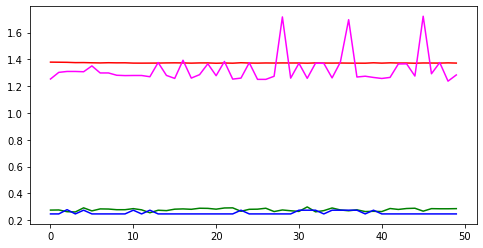

In [33]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()

In [34]:
df_test = pd.read_csv(folder + r'\alltestfiles.csv')
df_test = df_test[df_test.label!='pneumonia']
# This next line is to use only x% of the data
df_test = df_test.sample(n = df_test.shape[0]//20)
print(df_test['label'].value_counts())
print(df_test.shape)

FileNotFoundError: [Errno 2] File C:\Users\arung\OneDrive\Desktop\COVID 19 Chest Xray\nih\alltestfiles.csv does not exist: 'C:\\Users\\arung\\OneDrive\\Desktop\\COVID 19 Chest Xray\\nih\\alltestfiles.csv'

In [ ]:

test_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_whitening=False,
                                zca_epsilon=1e-06,
                                rotation_range=0,
                                width_shift_range=0.0,
                                height_shift_range=0.0,
                                brightness_range=None,
                                shear_range=0.0,
                                zoom_range=0.0,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=None,
                                preprocessing_function=preprocess,
                                data_format=None,
                                validation_split=0.0,
                                dtype=None,
                            )

test_set = test_datagen.flow_from_dataframe(
                                            dataframe=df_test,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode=None,
                                            batch_size=1,
                                            shuffle=False,
                                            seed=None,
                                            save_to_dir=folder + '\\test',
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            validate_filenames=True
                                        )


In [ ]:
pred=model.predict_generator(test_set,verbose=1,steps=len(test_set)/1 )



In [ ]:
(len(pred))

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

predicted_class_indices.shape

In [ ]:
conf = np.zeros([NUMCLASSES,NUMCLASSES],'float32')
count = 0
for row in df_test['label']:
    if row=='normal':
        realclass = 0
    else:
        realclass = 1
    try:
        conf[realclass,predicted_class_indices[count]] += 1
    except:
        break
    count += 1
    
conf[0,:] /= 496
conf[1,:] /= 779
conf

In [16]:
conf = np.zeros([NUMCLASSES,NUMCLASSES],'float32')
for row in rnage(len(test_set)):
    realclass = np.argmax(test_set[row][1])
    conf[realclass, predicted_class_indecies[row]] += 1
    
conf

,col1,col2
0,1,a
2,3,c
1,2,b
3,4,d


In [ ]:
for row in range(conf.shape):
    conf[row,:] /= sum(conf[row,:])
    
conf